In [1]:
import re
import time
import glob
import os.path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tbparse import SummaryReader
from torch.utils.tensorboard import SummaryWriter

In [5]:
pd.options.mode.copy_on_write = True


def load_logged_data(logdir, extraction_pattern):

    reader = SummaryReader(logdir)
    match = re.match(extraction_pattern, logdir)

    df = reader.scalars
    df['logdir'] = logdir
    df['seed'] = int(match.group("seed"))
    df['sensor_confidence'] = float(match.group("sensor_confidence"))
    
    return df


def preprocess_results(df):
    
    epsilon_data = df[df.tag.str.contains(r'algo/.*/epsilon')]
    reward_data = df[df.tag.str.contains(r'.*/reward/.*')]
    num_steps_data = df[df.tag.str.contains(r'.*/num_steps/.*')]
    
    # Keep only rows where epsilon = 1, as they allow to derive the episodes where a new RM was learnt
    droppable = epsilon_data[epsilon_data.value != 1.0].index
    epsilon_data = epsilon_data.drop(droppable)
    
    # Convert -1 rewards to 0, as for the final results we do not care about the difference between timeouts and failures
    reward_data.loc[reward_data.value < 0, 'value'] = 0
    
    return epsilon_data, reward_data, num_steps_data


def separate_and_concatenate(all_dfs):

    all_ttcs, all_ttrs = [], []
    all_ep_rewards, all_ep_steps = [], []
    all_eval_rewards, all_eval_steps = [], []
    for df in all_dfs:
        eps, rew, steps = preprocess_results(df)
        ttr, ttc = rm_quality_metrics(eps, rew)
        ep_rewards, ep_steps = agent_performance_metrics(rew, steps)
        eval_rewards, eval_steps = agent_last_evaluation_metrics(rew, steps)

        all_ttrs.append(ttr)
        all_ttcs.append(ttc)
        all_ep_rewards.append(ep_rewards)
        all_ep_steps.append(ep_steps)
        all_eval_rewards.append(eval_rewards)
        all_eval_steps.append(eval_steps)

    ttrs = pd.concat(all_ttrs)
    ttcs = pd.concat(all_ttcs)
    ep_rewards = pd.concat(all_ep_rewards)
    ep_steps = pd.concat(all_ep_steps)
    eval_rewards = pd.concat(all_eval_rewards)
    eval_steps = pd.concat(all_eval_steps)

    return ttrs, ttcs, ep_rewards, ep_steps, eval_rewards, eval_steps


def write_preprocess_data(out_dir, epsilon_df, reward_df, num_steps_df):

    writer = SummaryWriter(out_dir)

    for index, row in epsilon_df.iterrows():
        curr_step = row["step"]
        writer.add_scalar(row["tag"], row['value'], curr_step)

    for index, row in reward_df.iterrows():
        curr_step = row["step"]
        writer.add_scalar(row["tag"], row['value'], curr_step)

    for index, row in num_steps_df.iterrows():
        curr_step = row["step"]
        writer.add_scalar(row["tag"], row['value'], curr_step)


def rm_quality_metrics(eps_df, reward_df):
    
    # Compute Time-to_RM
    time_to_rm = eps_df.groupby(['tag', 'logdir', 'seed', 'sensor_confidence']).agg({'step': 'max'}).reset_index()
    time_to_rm['step'] = time_to_rm['step'] - 1
    time_to_rm = time_to_rm.rename(columns={'step': 'Time-to-RM'})
    time_to_rm["agent"] = time_to_rm["tag"].str.rsplit('/').str[1]
    time_to_rm = time_to_rm.drop(columns='tag')
    time_to_rm = time_to_rm.set_index(['logdir', 'agent'])
    
    # Compute Time-to-Convergence -> TODO: Fix
    n_eval_steps = reward_df.loc[reward_df.tag.str.contains(r'eval'), 'step'].max()
    n_training_steps = reward_df.loc[reward_df.tag.str.contains(r'training'), 'step'].max()
    eval_frequency = n_training_steps / n_eval_steps
    
    failures_selector = (reward_df.tag.str.contains(r'eval')) & (reward_df.value == 0.0)
    failure_rows = reward_df[failures_selector]
    success_selector = (reward_df.tag.str.contains(r'eval')) & (reward_df.value == 1.0)
    success_rows = reward_df[success_selector]
    
    if len(failure_rows.index) == 0:
        time_to_conv_value = 1
    elif len(success_rows.index) == 0:
        time_to_conv_value = pd.NA
    else:
        last_failure_rows = failure_rows.groupby(['tag', 'logdir', 'seed', 'sensor_confidence']).agg({'step': 'max'}).reset_index(drop=True)
        last_failure_rows[last_failure_rows.step == n_eval_steps] = pd.NA
        time_to_conv_value = (last_failure_rows["step"] * eval_frequency) - time_to_rm.iloc[0]["Time-to-RM"]
        
    time_to_conv = failure_rows.groupby(['tag', 'logdir', 'seed', 'sensor_confidence']).head(n=1).reset_index(drop=True)
    time_to_conv = time_to_conv.drop(columns=['value', 'step'])
    time_to_conv['Time-to-Conv'] = time_to_conv_value
    time_to_conv = convert_tag_to_env(time_to_conv)
    time_to_conv = time_to_conv.set_index(['logdir', 'env'])
    
    return time_to_rm, time_to_conv


def convert_tag_to_env(df):

    df['env'] = df['tag'].str.rsplit('/', n=1).str[1]
    df = df.drop(columns='tag')
    
    return df


def agent_performance_metrics(reward_df, num_steps_df):
    
    droppable_rewards = reward_df[reward_df.tag.str.contains(r'eval')].index
    episode_rewards = reward_df.drop(droppable_rewards)
    episode_rewards = convert_tag_to_env(episode_rewards)
    episode_rewards = episode_rewards.rename(columns={'step': 'episode'})
    episode_rewards = episode_rewards.set_index(['logdir', 'env', 'episode'])
    
    droppable_steps = num_steps_df[num_steps_df.tag.str.contains(f'eval')].index
    episode_steps = num_steps_df.drop(droppable_steps)
    episode_steps = convert_tag_to_env(episode_steps)
    episode_steps = episode_steps.rename(columns={'step': 'episode'})
    episode_steps = episode_steps.set_index(['logdir', 'env', 'episode'])
    
    return episode_rewards, episode_steps


def agent_last_evaluation_metrics(reward_df, num_steps_df):
    
    # Drop training-time data
    eval_rewards = reward_df.drop(reward_df[reward_df.tag.str.contains(r'training')].index)
    eval_num_steps = num_steps_df.drop(num_steps_df[num_steps_df.tag.str.contains(r'training')].index)
    
    # Keep only the data relating to the last evaluation
    droppable = eval_rewards[eval_rewards.step != eval_rewards.step.max()].index
    eval_rewards = eval_rewards.drop(droppable)
    droppable = eval_num_steps[eval_num_steps.step != eval_num_steps.step.max()].index
    eval_num_steps = eval_num_steps.drop(droppable)
    
    eval_rewards = convert_tag_to_env(eval_rewards)
    eval_num_steps = convert_tag_to_env(eval_num_steps)
    
    eval_rewards = eval_rewards.drop(columns='step')
    eval_num_steps = eval_num_steps.drop(columns='step')
    
    eval_rewards = eval_rewards.rename(columns={'value': 'reward'})
    eval_num_steps = eval_num_steps.rename(columns={'value': 'num_steps'})
    
    eval_rewards = eval_rewards.set_index(['logdir', 'env'])
    eval_num_steps = eval_num_steps.set_index(['logdir', 'env'])
    
    return eval_rewards, eval_num_steps


def aggregate_ttrs(df):
    
    df = df.reset_index()
    df = df.groupby(['sensor_confidence']).agg({
        'Time-to-RM': [
            'mean',
            'std',
            'median'
        ]})
    
    return df


def aggregate_ttcs(df):
    
    df = df.reset_index()
    df = df.groupby(['sensor_confidence']).agg({
        'Time-to-Conv': [
            'mean',
            'std',
            'median'
        ]
    })
    
    return df


def aggregate_rewards(df):
    
    df = df.reset_index()
    df = df.groupby(['sensor_confidence', 'episode']).agg({
        'value': [
            'mean',
            'std',
            'median',
            lambda x: np.percentile(x, q=25),
            lambda x: np.percentile(x, q=75)
            
        ]
    })

    df = df.rename(level=1, columns={
        '<lambda_0>': '25-perc',
        '<lambda_1>': '75-perc'
    })
    
    return df


def aggregate_num_steps(df):

    df = df.reset_index()
    df = df.groupby(['sensor_confidence', 'episode']).agg({
        'value': [
            'mean',
            'std',
            'median',
            lambda x: np.percentile(x, q=25),
            lambda x: np.percentile(x, q=75)
        ]
    })

    df = df.rename(level=1, columns={
        '<lambda_0>': '25-perc',
        '<lambda_1>': '75-perc'
    })

    return df


def aggregate_eval_rewards(df):
    
    df = df.reset_index()
    df = df.groupby(['sensor_confidence']).agg({
        'reward': [
            'mean',
            'std'
        ]
    })
    
    return df


def aggregate_eval_steps(df):

    df = df.reset_index()
    df = df.groupby(['sensor_confidence']).agg({
        'num_steps': [
            'mean',
            'std'
        ]
    })

    return df


def export_aggregated_eval_metrics(outfile, rewards_df, steps_df):

    merged = pd.concat((rewards_df, steps_df), axis='columns')
    merged.to_csv(outfile)


# Results processing for a single agent

In [ ]:
log_dir = '../results/preprocessed/with_rm_deliver_coffee/with_rm_deliver_coffee_0_1'
file_pattern = r"(.*)_(?P<seed>\d+)_(?P<sensor_confidence>[\d.]+)" 
df = load_logged_data(log_dir, file_pattern)

In [ ]:
df

In [ ]:
eps, rew, steps = preprocess_results(df)

In [ ]:
eps

In [ ]:
rew

In [ ]:
steps

In [ ]:
ttr, ttc = rm_quality_metrics(eps, rew)

In [ ]:
ttr

In [ ]:
ttc

In [ ]:
ep_rewards, ep_steps = agent_performance_metrics(rew, steps)

In [ ]:
ep_rewards

In [ ]:
ep_steps

In [ ]:
eval_rewards, eval_steps = agent_last_evaluation_metrics(rew, steps)

In [ ]:
eval_rewards

In [ ]:
eval_steps

# Multiple logdirs aggregation

In [10]:
SESSION = 'all_deliver_coffee'
log_dirs = glob.glob(f'../results/preprocessed/{SESSION}/*')
file_pattern = r"(.*)_(?P<seed>\d+)_(?P<sensor_confidence>[\d.]+)" 
all_dfs = [load_logged_data(logdir, file_pattern) for logdir in log_dirs]

In [11]:
ttrs, ttcs, ep_rewards, ep_steps, eval_rewards, eval_steps = separate_and_concatenate(all_dfs)

In [ ]:
ttrs

In [ ]:
ttcs

In [ ]:
ep_rewards

In [ ]:
ep_steps

In [ ]:
eval_rewards

In [ ]:
eval_steps

In [ ]:
agg_ttrs = aggregate_ttrs(ttrs)
agg_ttrs

In [ ]:
agg_ttcs = aggregate_ttcs(ttcs)
agg_ttcs

In [12]:
agg_ep_rewards = aggregate_rewards(ep_rewards)
agg_ep_rewards

value                                 
                               mean       std median 25-perc 75-perc
sensor_confidence episode                                           
0.99375           1        0.033333  0.182574    0.0     0.0     0.0
                  2        0.000000  0.000000    0.0     0.0     0.0
                  3        0.000000  0.000000    0.0     0.0     0.0
                  4        0.066667  0.253708    0.0     0.0     0.0
                  5        0.033333  0.182574    0.0     0.0     0.0
...                             ...       ...    ...     ...     ...
1.00000           9996     0.933333  0.253708    1.0     1.0     1.0
                  9997     0.966667  0.182574    1.0     1.0     1.0
                  9998     0.866667  0.345746    1.0     1.0     1.0
                  9999     0.933333  0.253708    1.0     1.0     1.0
                  10000    0.966667  0.182574    1.0     1.0     1.0

[40000 rows x 5 columns]

In [13]:
agg_num_steps = aggregate_num_steps(ep_steps)
agg_num_steps

value                                  
                                mean        std median 25-perc 75-perc
sensor_confidence episode                                             
0.99375           1        70.466667  72.744111   39.0   13.00  118.50
                  2        75.233333  88.280385   29.5    6.00  108.25
                  3        84.500000  79.073842   64.0   11.25  147.25
                  4        65.433333  73.565211   38.0    7.25  103.00
                  5        66.566667  66.834166   41.5   17.50   87.00
...                              ...        ...    ...     ...     ...
1.00000           9996     18.233333   6.595104   19.5   14.00   22.75
                  9997     18.066667   6.627702   17.0   15.00   22.00
                  9998     17.966667   7.676580   17.0   13.00   22.00
                  9999     18.033333   7.554324   18.0   13.50   21.75
                  10000    17.433333   6.856577   17.5   13.00   21.00

[40000 rows x 5 columns]

In [ ]:
agg_eval_rewards = aggregate_eval_rewards(eval_rewards)
agg_eval_rewards

In [ ]:
agg_eval_steps = aggregate_eval_steps(eval_steps)
agg_eval_steps

In [14]:
export_aggregated_eval_metrics('../results/plots/all_deliver_coffee_eval.csv', agg_eval_rewards, agg_eval_steps)

NameError: name 'agg_eval_rewards' is not defined

## Visualizations

In [15]:
def plot_mean_episodic_metric(agg_metric_df, *,
                              yaxis='',
                              smooth=False,
                              filename=None,
                              posteriors=(0.5, 0.8, 0.9, 1.0),
                              line_colors=('red', 'orange', 'forestgreen', 'royalblue')):
    
    agg_metric_df = agg_metric_df.reset_index().set_index('sensor_confidence')

    plt.figure(figsize=(6, 5), dpi=150)

    sensor_confidences = list(agg_metric_df.index.unique().sort_values().array)

    for index in agg_metric_df.index.unique():
        
        episodes = agg_metric_df.loc[index, 'episode']
        mean_rewards = agg_metric_df.loc[index, ('value', 'mean')]
        
        line_color = line_colors[sensor_confidences.index(index)]
        plot_label = posteriors[sensor_confidences.index(index)]

        if smooth:
            window_size = 100

            # Compute stddev of values over smoothing window to plot shaded area to represent variability
            windowed_stddev = mean_rewards.rolling(window=window_size).std()
            mean_rewards = mean_rewards.rolling(window=window_size).mean()
            
            shade_upper = mean_rewards + windowed_stddev
            shade_lower = mean_rewards - windowed_stddev
            
            plt.gca().fill_between(
                episodes, 
                shade_lower, 
                shade_upper,
                color=line_color,
                alpha=0.2
                
            )
            
        plt.plot(episodes, mean_rewards,
                 linewidth='0.5' if not smooth else 1.5,
                 label=plot_label,
                 color=line_color
        )
        
        plt.ylabel(f'Average {yaxis}')
        plt.xlabel('Episodes')
        plt.ylim(-0.05, 1.05)
        plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

    plt.legend(title='Posterior')
    plt.grid(linewidth=0.3)

    if filename is not None:
        plt.savefig(filename)


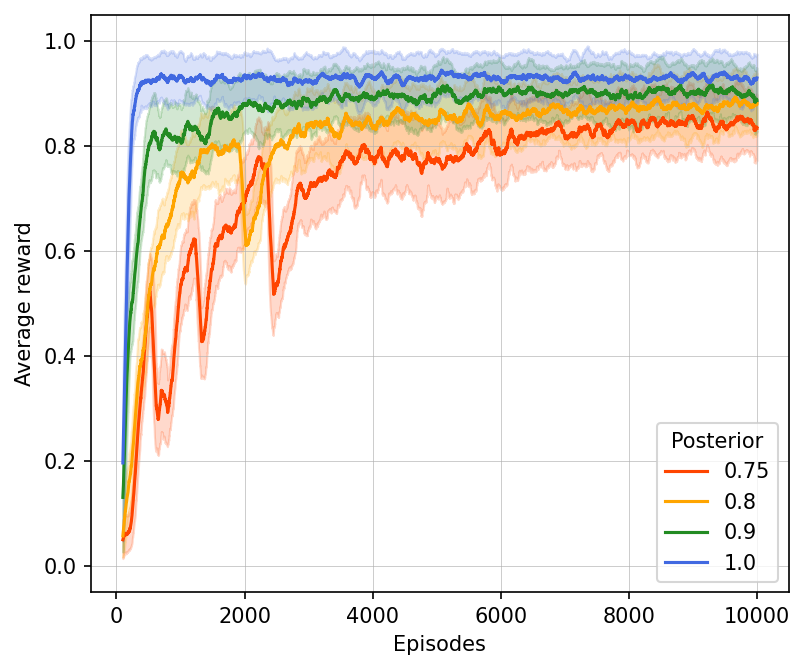

In [16]:
plot_mean_episodic_metric(agg_ep_rewards, yaxis='reward', smooth=True, filename=f'../results/plots/all_deliver_coffee_rewards.png', posteriors=(0.75, 0.8, 0.9, 1.0), line_colors=('orangered', 'orange', 'forestgreen', 'royalblue'))

# Thresholding comparison

In [6]:
def plot_thresholding_results(agg_metric_t07, agg_metric_t09, *,
                              smooth=True):
    
    agg_metric_t07 = agg_metric_t07.reset_index()
    agg_metric_t09 = agg_metric_t09.reset_index()

    plt.figure(figsize=(6, 5), dpi=150)

    # Plot lower threshold ie: the one that, in theory, should work
    episodes = agg_metric_t07['episode']
    mean_rewards = agg_metric_t07[('value', 'mean')]

    if smooth:
        window_size = 100

        # Compute stddev of values over smoothing window to plot shaded area to represent variability
        windowed_stddev = mean_rewards.rolling(window=window_size).std()
        mean_rewards = mean_rewards.rolling(window=window_size).mean()

        shade_upper = mean_rewards + windowed_stddev
        shade_lower = mean_rewards - windowed_stddev

        plt.gca().fill_between(
            episodes,
            shade_lower,
            shade_upper,
            color="forestgreen",
            alpha=0.2

        )

    plt.plot(episodes, mean_rewards,
             linewidth='0.5' if not smooth else 1.5,
             label="0.7",
             color="forestgreen"
             )
    
    # Plot higher threshold ie: the one that, in theory, should not work
    episodes = agg_metric_t09['episode']
    mean_rewards = agg_metric_t09[('value', 'mean')]

    if smooth:
        window_size = 100

        # Compute stddev of values over smoothing window to plot shaded area to represent variability
        windowed_stddev = mean_rewards.rolling(window=window_size).std()
        mean_rewards = mean_rewards.rolling(window=window_size).mean()

        shade_upper = mean_rewards + windowed_stddev
        shade_lower = mean_rewards - windowed_stddev

        plt.gca().fill_between(
            episodes,
            shade_lower,
            shade_upper,
            color="red",
            alpha=0.2

        )

    plt.plot(episodes, mean_rewards,
             linewidth='0.5' if not smooth else 1.5,
             label="0.9",
             color="red"
             )

    plt.ylabel(f'Average reward')
    plt.xlabel('Episodes')
    plt.ylim(-0.05, 1.05)
    plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

    plt.legend(title='Threshold')
    plt.grid(linewidth=0.3)

    plt.savefig('../results/plots/thresholding_comparison.png')



In [8]:
log_dirs = glob.glob(f'../results/preprocessed/all_t-0.7_deliver_coffee/*')
file_pattern = r"(.*)_(?P<seed>\d+)_(?P<sensor_confidence>[\d.]+)"
t7_all_dfs = [load_logged_data(logdir, file_pattern) for logdir in log_dirs]

log_dirs = glob.glob(f'../results/preprocessed/all_t-0.9_deliver_coffee/*')
file_pattern = r"(.*)_(?P<seed>\d+)_(?P<sensor_confidence>[\d.]+)"
t9_all_dfs = [load_logged_data(logdir, file_pattern) for logdir in log_dirs]


_, _, t7_ep_rewards, _, _, _ = separate_and_concatenate(t7_all_dfs)
_, _, t9_ep_rewards, _, _, _ = separate_and_concatenate(t9_all_dfs)

t7_agg_ep_rewards = aggregate_rewards(t7_ep_rewards)
t9_agg_ep_rewards = aggregate_rewards(t9_ep_rewards)


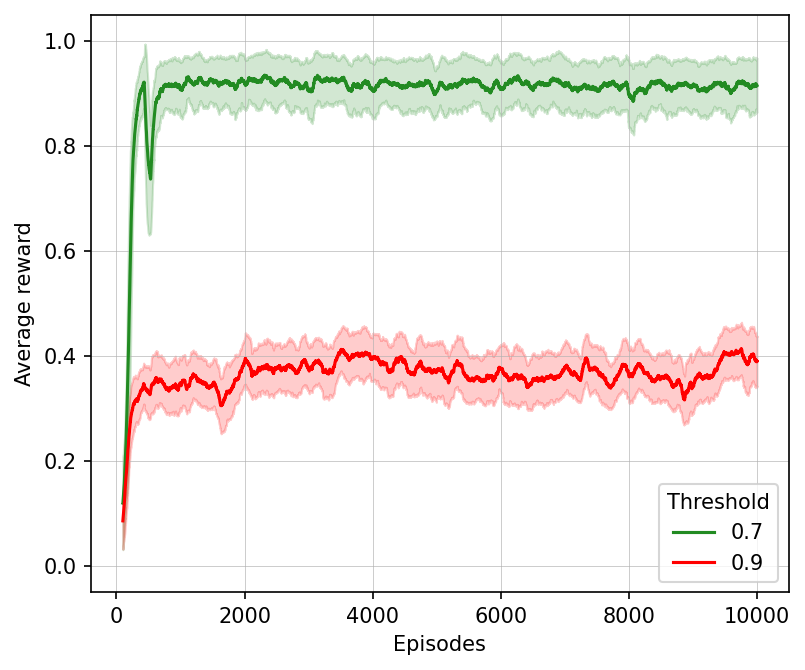

In [9]:
plot_thresholding_results(t7_agg_ep_rewards, t9_agg_ep_rewards)

# Sensor confidence to posteriors conversion

In [ ]:
from sympy import *
  
def sensitivity_specificity_from_posterior(posterior, prior):
    x = symbols('x')
    f = posterior - (x * prior)/(x * prior + (1 - x)* (1-prior))
    return solve(f, x)[0]
 
priors = [2/108]
posteriors = [0.75, 0.6]
 
for _pr in priors:
    for _po in posteriors:
        print(f"Prior: [{_pr}], Posterior: [{_po}], Sensor confidence: [{sensitivity_specificity_from_posterior(_po, _pr)}]")